In [78]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [79]:
# Reproducibility

np.random.seed(42)
torch.manual_seed(42)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data

(20,)
(20,)


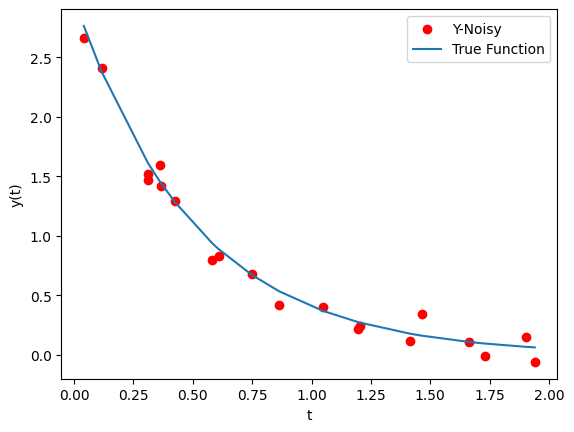

In [80]:
n_points = 20
sigma = 0.1

t_np = np.sort(np.random.uniform(0.0, 2.0, size=n_points))
y_exact_np = 3.0 * np.exp(-2 * t_np)
y_noisy_np = y_exact_np + np.random.normal(0.0, sigma, n_points)


print(t_np.shape)
print(y_noisy_np.shape)


plt.scatter(t_np, y_noisy_np, label="Y-Noisy", color="red")
plt.plot(t_np, y_exact_np, label="True Function")
plt.legend()
plt.xlabel("t")
plt.ylabel("y(t)")
plt.show()

### Torch Data

In [81]:
t_data = torch.from_numpy(t_np).float().reshape(-1, 1).to(devive)
y_noisy = torch.from_numpy(y_noisy_np).float().reshape(-1, 1).to(device)

print(t_data.shape)
print(y_noisy.shape)

torch.Size([20, 1])
torch.Size([20, 1])


# Model

In [92]:
class TNet(nn.Module):
    def __init__(self, hidden=32):
        super().__init__()
        self.l1 = nn.Linear(1, hidden)
        self.l2 = nn.Linear(hidden, hidden)
        self.l3 = nn.Linear(hidden, 1)
        self.act = nn.Tanh()
        self.reset_parameters()
    
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.l1.weight); nn.init.zeros_(self.l1.bias)
        nn.init.xavier_uniform_(self.l2.weight); nn.init.zeros_(self.l2.bias)
        nn.init.xavier_uniform_(self.l3.weight); nn.init.zeros_(self.l3.bias)
                                                                
    def forward(self, x):
        x = self.act(self.l1(x))
        x = self.act(self.l2(x))
        x = self.l3(x)
        return x
                                                                
model = TNet().to(device)
mse = nn.MSELoss()
print("Param-Anzahl:", sum(p.numel() for p in model.parameters()))

Param-Anzahl: 1153


### Loss definieren

In [99]:
def pinn_losses(model, t_data, y_noisy, t_phys, ic_value=3.0):  # pinn_losses (2 n)
    # 1) Data loss
    y_hat = model(t_data)
    data_loss = mse(y_hat, y_noisy)

    # 2) Physics loss: (dy/dt + 2*y)^2 über Kollokationspunkte
    t_phys_req = t_phys.clone().detach().to(device).requires_grad_(True)  # clone(), requires_grad_
    y_phys = model(t_phys_req)

    dy_dt = torch.autograd.grad(
        outputs=y_phys,
        inputs=t_phys_req,
        grad_outputs=torch.ones_like(y_phys),
        create_graph=True,
        retain_graph=True,
        only_inputs=True
    )[0]

    residual = dy_dt + 2.0 * y_phys
    physics_loss = mse(residual, torch.zeros_like(residual))

    # 3) IC-Loss: (y(0) - 3)^2
    t0 = torch.zeros(1, 1, device=device)
    y0_hat = model(t0)
    ic_loss = mse(y0_hat, torch.tensor([[ic_value]], dtype=torch.float32, device=device))

    total = data_loss + physics_loss + ic_loss
    return total, data_loss.detach(), physics_loss.detach(), ic_loss.detach()

### Training

In [101]:
epochs = 2000
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

t_phys = torch.linspace(0.0, 2.0, steps=200).reshape(-1, 1).to(device)

for ep in range(1, epochs + 1):
    optimizer.zero_grad()
    total, dL, pL, icL = pinn_losses(model, t_data, y_noisy, t_phys)
    total.backward()
    optimizer.step()

    if ep % 100 == 0:
        print(f"epoch {ep:4d} | total {total.item():.6f} | data {dL.item():.6f} | phys {pL.item():.6f} | ic {icL.item():.6f}")
 

epoch  100 | total 0.020801 | data 0.008401 | phys 0.011040 | ic 0.001360
epoch  200 | total 0.011384 | data 0.008431 | phys 0.002792 | ic 0.000161
epoch  300 | total 0.009824 | data 0.008480 | phys 0.001241 | ic 0.000103
epoch  400 | total 0.009258 | data 0.008474 | phys 0.000696 | ic 0.000088
epoch  500 | total 0.008958 | data 0.008453 | phys 0.000423 | ic 0.000081
epoch  600 | total 0.008792 | data 0.008436 | phys 0.000278 | ic 0.000078
epoch  700 | total 0.008702 | data 0.008427 | phys 0.000200 | ic 0.000075
epoch  800 | total 0.008669 | data 0.008383 | phys 0.000206 | ic 0.000080
epoch  900 | total 0.008635 | data 0.008410 | phys 0.000150 | ic 0.000074
epoch 1000 | total 0.008630 | data 0.008390 | phys 0.000160 | ic 0.000080
epoch 1100 | total 0.008618 | data 0.008403 | phys 0.000141 | ic 0.000073
epoch 1200 | total 0.008610 | data 0.008401 | phys 0.000136 | ic 0.000073
epoch 1300 | total 0.008658 | data 0.008496 | phys 0.000105 | ic 0.000057
epoch 1400 | total 0.008610 | data 0.0

In [102]:
# Vorhersagekurven für Plot
t_dense = np.linspace(0.0, 2.0, 400).reshape(-1,1).astype(np.float32)
y_exact_dense = 3.0 * np.exp(-2.0 * t_dense[:,0])


with torch.no_grad():
    y_pred_dense = model(torch.from_numpy(t_dense).to(device)).cpu().numpy()[:,0]

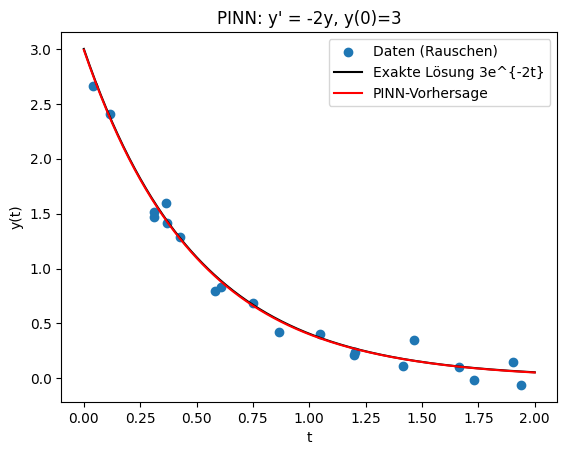

In [103]:
plt.figure()
plt.scatter(t_np, y_noisy_np, label="Daten (Rauschen)", color="C0")
plt.plot(t_dense[:,0], y_exact_dense, label="Exakte Lösung 3e^{-2t}", color="black")
plt.plot(t_dense[:,0], y_pred_dense, label="PINN-Vorhersage", color="red")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.legend(); plt.title("PINN: y' = -2y, y(0)=3")
plt.show()

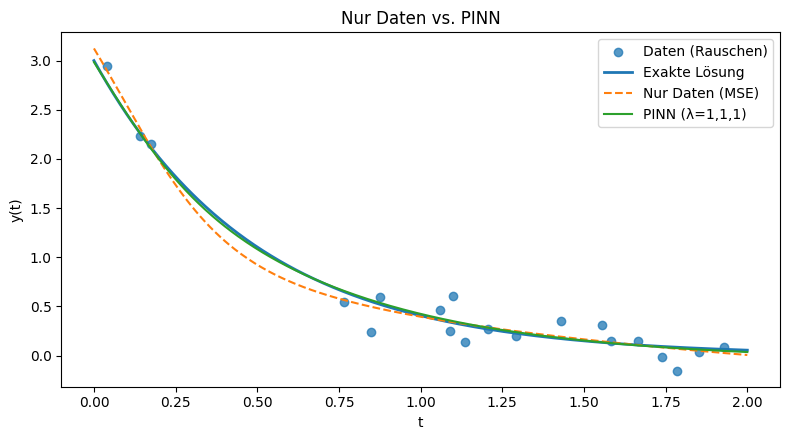

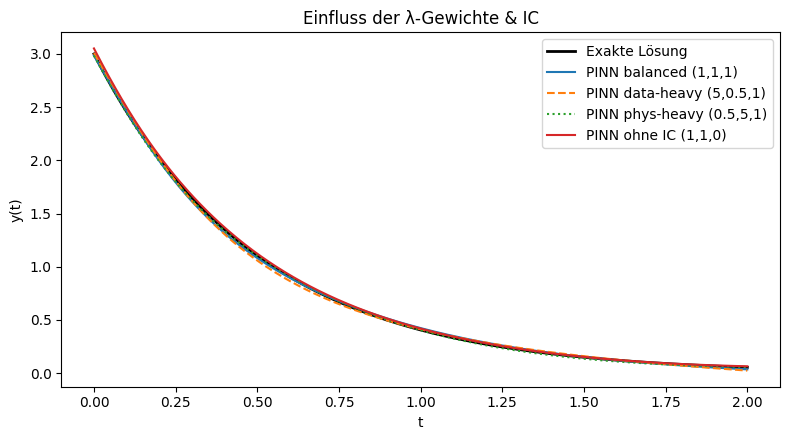

In [104]:
# Data-only vs PINN comparison + lambda effects demo
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

torch.manual_seed(0)
np.random.seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# --- Data generation: y' = -2y, y(0)=3 ---
n_points = 20
sigma = 0.12
t_np = np.sort(np.random.uniform(0.0, 2.0, size=n_points)).astype(np.float32)
y_true_np = (3.0 * np.exp(-2.0 * t_np)).astype(np.float32)
y_noisy_np = (y_true_np + np.random.normal(0.0, sigma, n_points)).astype(np.float32)

t_data = torch.from_numpy(t_np).float().reshape(-1,1).to(device)
y_noisy = torch.from_numpy(y_noisy_np).float().reshape(-1,1).to(device)

# Dense grid for plotting
t_grid = np.linspace(0, 2, 400).astype(np.float32).reshape(-1,1)
y_true_grid = 3.0 * np.exp(-2.0 * t_grid[:,0])
t_grid_t = torch.from_numpy(t_grid).to(device)

# --- Model (alternative style, no Sequential) ---
class Net(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(1, hidden)
        self.fc2 = nn.Linear(hidden, hidden)
        self.fc3 = nn.Linear(hidden, 1)
        nn.init.xavier_uniform_(self.fc1.weight); nn.init.zeros_(self.fc1.bias)
        nn.init.xavier_uniform_(self.fc2.weight); nn.init.zeros_(self.fc2.bias)
        nn.init.xavier_uniform_(self.fc3.weight); nn.init.zeros_(self.fc3.bias)
    def forward(self, x):
        x = torch.tanh(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        x = self.fc3(x)
        return x

mse = nn.MSELoss()

def grad_wrt_t(y, t):
    return torch.autograd.grad(y, t, grad_outputs=torch.ones_like(y), create_graph=True)[0]

def train_data_only(epochs=300, lr=5e-3):
    model = Net().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    for ep in range(epochs):
        opt.zero_grad()
        pred = model(t_data)
        loss = mse(pred, y_noisy)
        loss.backward()
        opt.step()
    with torch.no_grad():
        pred_grid = model(t_grid_t).cpu().numpy()[:,0]
    return model, pred_grid

def train_pinn(lambda_data=1.0, lambda_phys=1.0, lambda_ic=1.0, epochs=300, lr=5e-3, n_phys=60):
    model = Net().to(device)
    opt = optim.Adam(model.parameters(), lr=lr)
    t_phys_base = torch.linspace(0.0, 2.0, steps=n_phys).reshape(-1,1).to(device)
    for ep in range(epochs):
        # data
        y_hat = model(t_data)
        loss_data = mse(y_hat, y_noisy)
        # physics (with slight jitter each epoch)
        t_phys = (t_phys_base + 0.01*torch.randn_like(t_phys_base)).clamp(0,2).requires_grad_(True)
        y_phys = model(t_phys)
        dy_dt = grad_wrt_t(y_phys, t_phys)
        resid = dy_dt + 2.0*y_phys
        loss_phys = (resid**2).mean()
        # initial condition
        t0 = torch.zeros(1,1, device=device, requires_grad=True)
        y0_hat = model(t0)
        loss_ic = (y0_hat - torch.tensor([[3.0]], device=device))**2
        loss_ic = loss_ic.mean()
        # total
        loss = lambda_data*loss_data + lambda_phys*loss_phys + lambda_ic*loss_ic
        opt.zero_grad()
        loss.backward()
        opt.step()
    with torch.no_grad():
        pred_grid = model(t_grid_t).cpu().numpy()[:,0]
    return model, pred_grid

# --- Train models ---
data_model, data_pred = train_data_only()

pinn_bal_model, pinn_bal_pred = train_pinn(lambda_data=1.0, lambda_phys=1.0, lambda_ic=1.0)

# Lambda effects (quick demo): more data weight, more phys weight, no IC
_, pinn_dataheavy = train_pinn(lambda_data=5.0, lambda_phys=0.5, lambda_ic=1.0, epochs=250)
_, pinn_physheavy = train_pinn(lambda_data=0.5, lambda_phys=5.0, lambda_ic=1.0, epochs=250)
_, pinn_noic      = train_pinn(lambda_data=1.0, lambda_phys=1.0, lambda_ic=0.0, epochs=250)

# --- Plot 1: Data-only vs PINN (balanced) ---
plt.figure(figsize=(8,4.5))
plt.scatter(t_np, y_noisy_np, label="Daten (Rauschen)", alpha=0.75)
plt.plot(t_grid[:,0], y_true_grid, label="Exakte Lösung", linewidth=2)
plt.plot(t_grid[:,0], data_pred, label="Nur Daten (MSE)", linestyle="--")
plt.plot(t_grid[:,0], pinn_bal_pred, label="PINN (λ=1,1,1)")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.title("Nur Daten vs. PINN")
plt.legend(); plt.tight_layout()
plt.show()

# --- Plot 2: Lambda effects ---
plt.figure(figsize=(8,4.5))
plt.plot(t_grid[:,0], y_true_grid, label="Exakte Lösung", linewidth=2, color="black")
plt.plot(t_grid[:,0], pinn_bal_pred, label="PINN balanced (1,1,1)")
plt.plot(t_grid[:,0], pinn_dataheavy, label="PINN data-heavy (5,0.5,1)", linestyle="--")
plt.plot(t_grid[:,0], pinn_physheavy, label="PINN phys-heavy (0.5,5,1)", linestyle=":")
plt.plot(t_grid[:,0], pinn_noic, label="PINN ohne IC (1,1,0)", linestyle="-")
plt.xlabel("t"); plt.ylabel("y(t)"); plt.title("Einfluss der λ-Gewichte & IC")
plt.legend(); plt.tight_layout()
plt.show()


# PINN: Data-only vs. PINN mit Physik und Einfluss der Gewichte

## Differentialgleichung

Wir betrachten die ODE:

$$
\frac{dy}{dt} = -2y, \quad y(0) = 3
$$

Die exakte Lösung ist:

$$
y(t) = 3 \, e^{-2t}
$$

---

## Bonusfragen

### 1) Warum reicht es nicht, nur den Data-Loss zu benutzen?

- Mit reinem **MSE** kann das Netz die **Messpunkte** gut treffen, aber dazwischen **beliebige Formen** annehmen.  
- Vor allem bei **wenigen oder verrauschten Daten** gibt es keine Garantie für physikalisch korrekte Lösungen.  
- **PINNs** fügen die Differentialgleichung als **Nebenbedingung** hinzu, sodass die Lösung auch **zwischen den Datenpunkten korrekt** bleibt.  

---

### 2) Was passiert, wenn man den IC-Loss weglässt?

- Die Differentialgleichung 

$$
\frac{dy}{dt} = -2y
$$ 

hat die allgemeine Lösung:

$$
y(t) = C \, e^{-2t}
$$

- Ohne die Anfangsbedingung 

$$
y(0) = 3
$$ 

ist die Konstante \(C\) **nicht eindeutig bestimmt**.  
- Das Netz kann also eine Lösung lernen, die die DGL erfüllt, aber **falsch skaliert** ist.  

---

### 3) Einfluss der Gewichte

Wir betrachten die Gewichtungsfaktoren:

$$
\lambda_\text{data}, \quad \lambda_\text{phys}, \quad \lambda_\text{ic}
$$

- **Großes \( \lambda_\text{data} \)**  
  → Modell passt stark an **Messpunkte** (inkl. Rauschen) an, kann aber **unphysikalisch** werden.  

- **Großes \( \lambda_\text{phys} \)**  
  → Modell folgt stärker der **Physik**, glättet zwischen den Datenpunkten, ignoriert aber evtl. einzelne Messpunkte.  

- **Großes \( \lambda_\text{ic} \)**  
  → **Anfangs-/Randwert** wird strikt eingehalten, was die **Integrationskonstanten** fixiert.  
  → Ohne IC-Loss ist die Lösung **nicht eindeutig**.  

---

## Merksatz

- **Daten** → Realität binden  
- **Physik** → Form zwischen Messpunkten bändigen  
- **IC/BC** → Integrationskonstanten fixieren
